In [22]:
from helper import *
import warnings
warnings.filterwarnings('ignore')

In [23]:
import pytorch_util as ptu
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import trange, tqdm_notebook

# Question 1: 2D Data

In this question, we will train two variants of flow models on continuous 2D data. 

Execute the cell below to visualize our datasets

Dataset 1


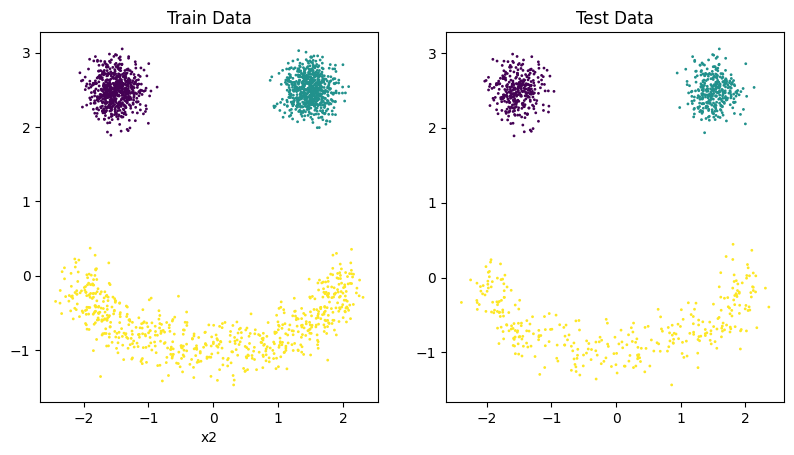

Dataset 2


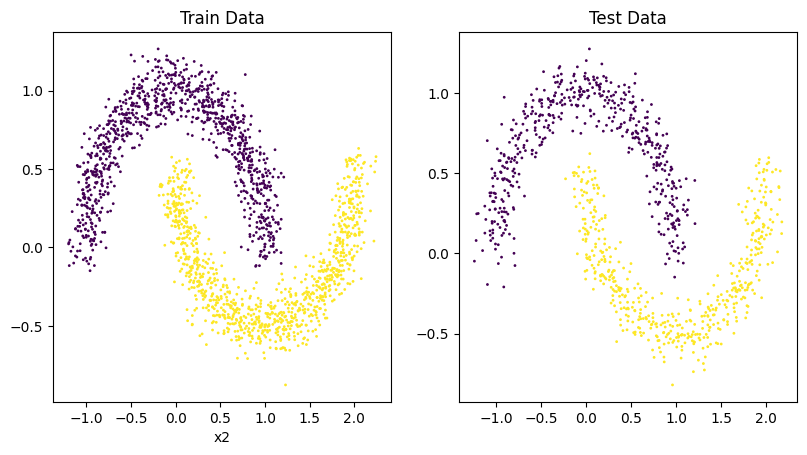

In [3]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Autoregressive Flow 

In an autoregressive flow, we learn the transformation $z_i = f(x_i ; x_{1:i-1})$. The log-likelihood is then $\log p_\theta(x) = \sum_{i=1}^d log p(z_i) + log |\frac{dz_i}{dx_i}|$ because the Jacobian is triangular. For each dimension, use the CDF of a mixture of Gaussians or Logistics to map to the latent space, which should be $z_i \sim \text{Unif}[0, 1]$ i.i.d..

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set. Since this is a 2D problem, you can either learn $z_0 = f(x_0)$ and $z_1 = f(x_1; x_0)$ together with a MADE model, or with separate networks. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**Over the course of training we will**


1. Record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Show a heatmap of the densities learned by your model
4. Show what the training set looks like when mapped to the latent space. 

In [4]:
import pytorch_util as ptu
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import trange, tqdm_notebook

def train(model, train_loader, optimizer):
    model.train()
    losses = []
    for x in train_loader:
        x = x.to(ptu.device).float().contiguous() # x is save in continuous blocks of memory w/o any skips
        loss = model.nll(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(ptu.device).float().contiguous()
            loss = model.nll(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)  # loss at init
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        model.train()
        epoch_train_losses = train(model, train_loader, optimizer) 
        train_losses.extend(epoch_train_losses)

        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
            
    return train_losses, test_losses

In [5]:
import copy
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from scipy.stats import norm

ptu.set_gpu_mode(True) # set ptu.device to cuda when True else cpu

class MixtureCDFFlow(nn.Module):
    def __init__(self, 
                 base_dist='uniform', 
                 mixture_dist='gaussian',
                 n_components=4,
                 plot_bounds=(-3,3)):
        super().__init__()
        self.composition = False
        if base_dist == 'uniform':
            self.base_dist = Uniform(0.0, 1.0)
        else:
            raise NotImplementedError
        # n_components = 5 - number of components in mixture of Gaussian distribution
        self.loc = nn.Parameter(torch.randn(n_components), requires_grad=True) # (n_componenst, ) represents means of components in the mixture of Gaussian distribution
        self.log_scale = nn.Parameter(torch.zeros(n_components), requires_grad=True) # (n_componenst, ) represents log(std) of components in the mixture of Gaussian distribution (initialized to all zeros), we take log so that output of the network can be from -inf to inf
        self.weight_logits = nn.Parameter(torch.zeros(n_components), requires_grad=True) # (n_components, ) -> mixture weights
        if mixture_dist == 'gaussian': # True
            self.mixture_dist = Normal
        elif mixture_dist == 'logistic':
            raise NotImplementedError
        self.n_components = n_components
        self.plot_bounds = plot_bounds

    def flow(self, x):
        # z = cdf of x
        # x = (128,)
        weights = F.softmax(self.weight_logits, dim=0).unsqueeze(0).repeat(x.shape[0], 1) #(128, 5) - replicates mixture weights 
        z = (self.mixture_dist(self.loc, self.log_scale.exp()).cdf(x.unsqueeze(1).repeat(1, self.n_components)) * weights).sum(dim=1) # (128,) calculates f(x_i) for every x_i in the dataset where f(x_i) is the flow - cdf of mixture of 5 gaussians
        
        # Since the flow is cdg mixture of Gaussians - derivative of flow is mixture of Gaussians itself
        # log_det = log dz/dx = log pdf(x)
        log_det = (self.mixture_dist(self.loc, self.log_scale.exp()).log_prob(x.unsqueeze(1).repeat(1, self.n_components)).exp() * weights).sum(dim=1).log() # (128,) calculates log (df(x_i)/d(x_i)) for every x_i in the dataset where f(x_i) is the flow - cdf of mixture of 5 gaussians

        return z, log_det

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return self.base_dist.log_prob(z) + log_det
 
    # Compute loss as negative log-likelihood
    def nll(self, x):
        return - self.log_prob(x).mean()

class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, hidden_size, output_size):
        super().__init__()
        layers = []
        '''
        input_size = 1
        n_hidden = 3 represents no. of hidden layers
        hidden_size = 64 
        output_size = dim2_n_components*3 - for each component, the MLP predicts mean, std and mixtire weight
        '''
        # MLP layer
        for _ in range(n_hidden):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

class AutoregressiveFlow(nn.Module):
    """
    Assumes that we're modeling a 2D distribution
    """
    def __init__(self, 
                 dim1_mixture_dist='gaussian', 
                 dim1_n_components=5, 
                 dim2_mixture_dist='gaussian', 
                 dim2_n_components=5,
                 mlp_hidden_size=64,
                 mlp_n_layers=3):
        super().__init__()
        # initializes flow model as cdf of mixture of 5 gaussians
        self.dim1_flow = MixtureCDFFlow(mixture_dist=dim1_mixture_dist, n_components=dim1_n_components).to(ptu.device)
        self.mlp = MLP(1, mlp_n_layers, mlp_hidden_size, dim2_n_components * 3).to(ptu.device) # MLP layer to calculate mean, std, mixture weights of mixture of 5 gaussians for x2 given x1
        self.dim2_n_components = dim2_n_components # n_components in mixture of gaussians for 2nd dim (x2)
        self.base_dist = Uniform(ptu.tensor(0.0), ptu.tensor(1.0)) # Uniform distribution from [0, 1) # target distribution
        if dim2_mixture_dist == 'gaussian':
            self.mixture_dist = Normal
        elif dim2_mixture_dist == 'logistic':
            raise NotImplementedError

    def flow(self, x):
        # individually flow on each dim
        x1, x2 = torch.chunk(x, 2, dim=1) #(128, 1), (128, 1) x1, x2 represents 1st and 2nd dim of x respectively
        
        # dim 1 
        z1, log_det1 = self.dim1_flow.flow(x1.squeeze()) # z1 = (128,) represnets flow transformed values for x1, log_det1 = (128,) represents df(x)/dx to calculate p(x) 
        
        # dim1
        # get mean. std and mixture weights for mixture of Gaussian distribution for x2 conditioned on x1
        loc, log_scale, weight_logits = torch.chunk(self.mlp(x1), 3, dim=1) #(128, 3)
        weights = F.softmax(weight_logits, dim=1) # softmax to normalize mixture weights
        
        # z2 from the mixture of gaussians obtained when conditioning on x1
        z2 = (self.mixture_dist(loc, log_scale.exp()).cdf(
            x2.repeat(1, self.dim2_n_components)) * weights).sum(dim=1)  # (128,) calculates f(x_i) for every x_i in the dataset where f(x_i) is the flow - cdf of mixture of 5 gaussians
        log_det2 = (self.mixture_dist(loc, log_scale.exp()).log_prob(
            x2.repeat(1, self.dim2_n_components)).exp() * weights).sum(dim=1).log() # (128,) calculates log (df(x_i)/d(x_i)) for every x_i in the dataset where f(x_i) is the flow - cdf of mixture of 5 gaussians
        return torch.cat([z1.unsqueeze(1), z2.unsqueeze(1)], dim=1), torch.cat([log_det1.unsqueeze(1), log_det2.unsqueeze(1)], dim=1)

    def log_prob(self, x):
        z, log_det = self.flow(x) # z = (128, 2), log-det = (128, 2) - contains z and log (df(x)/d(x))
        return (self.base_dist.log_prob(z) + log_det).mean(dim=1) # shape: [batch_size] # log ikelihood log(p(x))for every sample i.e. it calculates 𝑙𝑜𝑔𝑝(𝑧𝑖)+𝑙𝑜𝑔|𝑑𝑧𝑖𝑑𝑥𝑖|. Note that P(z) is Uniform and threfore it's 0 for all the samples
  

    def nll(self, x):
        return - self.log_prob(x).mean() # avg negative log likelihood

In [6]:

def q1_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
      mapping the train set data points through our flow to the latent space. 
    """
  
    # create data loaders
    loader_args = dict(batch_size=128, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)
    test_loader = data.DataLoader(test_data, **loader_args)

    # model
    ar_flow = AutoregressiveFlow()

    # train
    train_losses, test_losses = train_epochs(ar_flow, train_loader, test_loader, dict(epochs=100, lr=5e-3))

    # heatmap
    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = ptu.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
    densities = np.exp(ptu.get_numpy(ar_flow.log_prob(mesh_xs)))

    # latents
    z, _ = ar_flow.flow(ptu.FloatTensor(train_data))
    latents = ptu.get_numpy(z)

    return train_losses, test_losses, densities, latents

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Final Test Loss: 0.6578


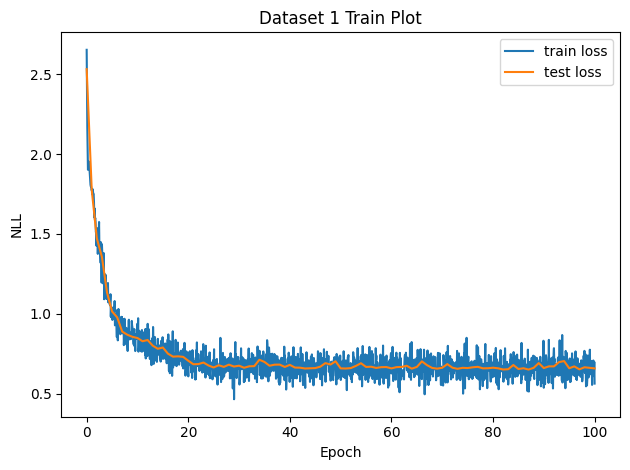

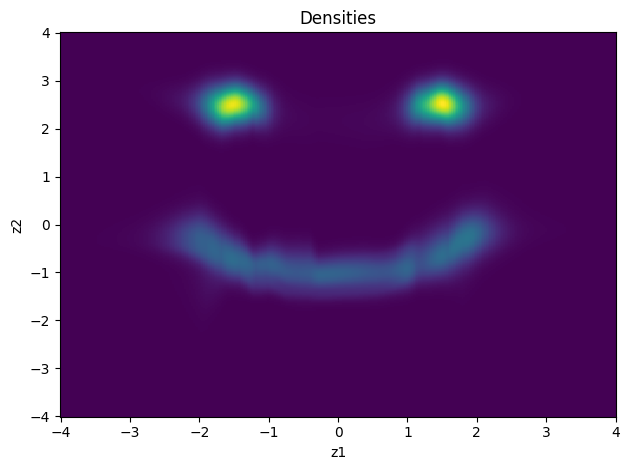

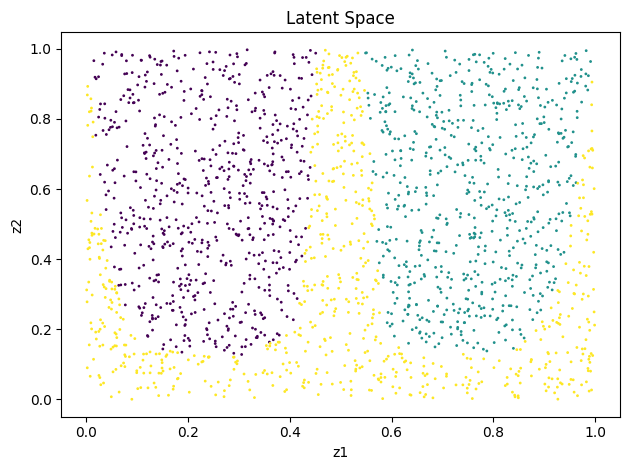

In [7]:
q1_save_results(1, 'a', q1_a)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Final Test Loss: 0.5602


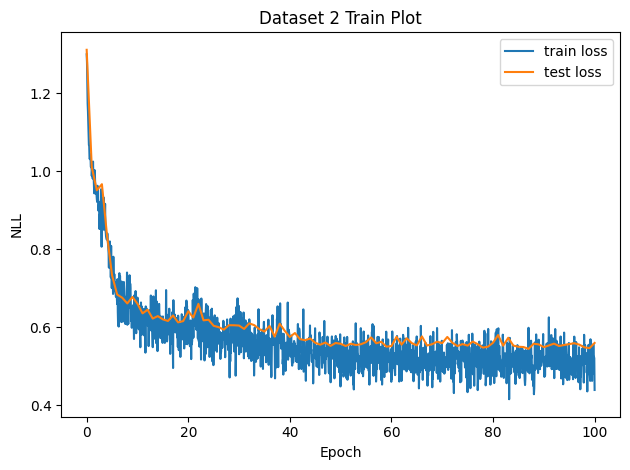

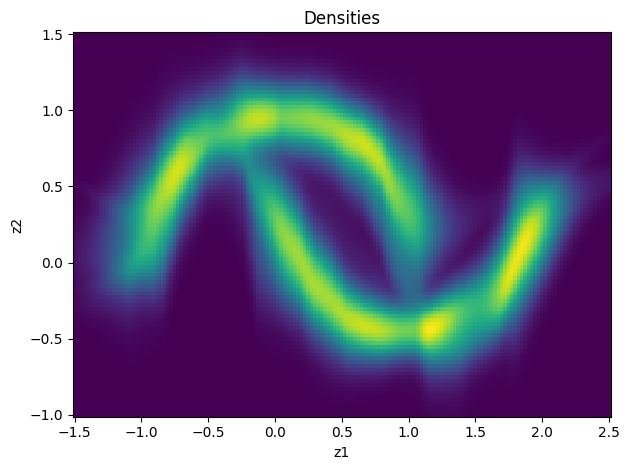

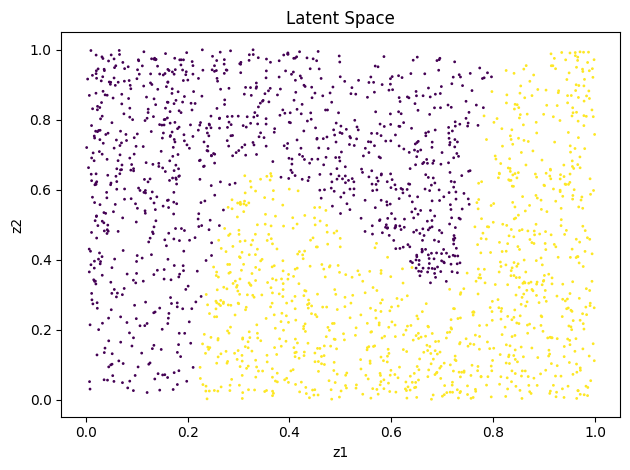

In [8]:
q1_save_results(2, 'a', q1_a)

## Part (b) RealNVP
In this part, we will train a flow with the following structure: 
$(z_1, z_2) = (f_{\theta, 1} \circ \cdots \circ f_{\theta, n})$, 
where each $f_{\theta, i}$ is an affine transformation of 1 dimension, conditioned on the other. According to [Density Estimation Using Real NVP](https://arxiv.org/abs/1605.08803) Section 4.1, there's a particularly good way to parameterize the affine transformation:

Assuming that we're conditioning on $x_1$ and transforming $x_2$, we have 

- $z_1 = x_1$

- $ \text{log_scale} = \text{scale} \times tanh(g_{\theta, \text{scale}}(x_1)) + \text{scale_shift}$

- $z_2 = exp(\text{log_scale}) \times x_2 + g_{\theta, \text{shift}}(x_1)$

where $g_\theta$, $\text{scale}$, and $\text{scale_shift}$ are all learned parameters. The latent space should be $z \sim \mathcal N (0, I_2)$.


In [9]:
class AffineTransform(nn.Module):
    def __init__(self, type, n_hidden, hidden_size=256):
        super().__init__()
        self.mask = self.build_mask(type=type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True).to(ptu.device)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True).to(ptu.device)
        self.mlp = MLP(input_size=2, n_hidden=n_hidden, hidden_size=hidden_size, output_size=2).to(ptu.device) #MLP with 2 hidden layers, output neurons = 2 (one each for scale and shift) 
    
    def build_mask(self, type):
        # if type == "left", left half is a one
        # if type == right", right half is a one
        
        assert type in {"left", "right"}
        if type == "left":
            mask = ptu.FloatTensor([1.0, 0.0])
        elif type == "right":
            mask = ptu.FloatTensor([0.0, 1.0])
        else:
            raise NotImplemetedError
        return mask
    
    def forward(self, x, reverse=False):
        # returns transform(x), log_det
        '''
        if type='left'
        
            Z1=X1
            log_scale=scale×𝑡𝑎𝑛ℎ(𝑔𝜃,scale(𝑥1))+scale_shift
            Z2=𝑒𝑥𝑝(log_scale) × X2 + 𝑔𝜃,shift(𝑥1)
            
        if type='right'
            log_scale=scale×𝑡𝑎𝑛ℎ(𝑔𝜃,scale(𝑥1))+scale_shift
            Z1=𝑒𝑥𝑝(log_scale) × X1 + 𝑔𝜃,shift(𝑥1)
            Z2=X2
            
            
        '''
        
        batch_size = x.shape[0]
        mask = self.mask.repeat(batch_size, 1) #(batch_size, 2)
        x_ = x*mask #(bs, 2) masking the input i.e. zeros 1st or 2nd dim
        log_s, t = self.mlp(x_).split(1, dim=1) # (bs,), #(bs,)
        log_s = self.scale*torch.tanh(log_s) + self.scale_shift # log_scale=scale×𝑡𝑎𝑛ℎ(𝑔𝜃,scale(𝑥1))+scale_shift
        # if type = left, 2nd dim = 1 as (no scaling snd shift for 1st dim) and vice versa
        t = t * (1.0 - mask) 
        log_s = log_s * (1.0 - mask)
        
        if reverse:
            x = (x - t)*torch.exp(-log_s) # inverse transform from z to x
        else:
            # from x to z
            x = x*torch.exp(log_s) + t # transform note - we predict log scale from MLP and therefor take exp()
        return x, log_s # in case of affine transformation, depending on the type, for one of the dim log(dz/dx) = log(1) = 0 and for the other dim log(dz/dx) = log(scale). 
    
class SigmoidFlow(nn.Module):
    def forward(self, x, reverse=False):
        if reverse:
            z = -torch.log(torch.reciprocal(x) - 1)
        else:
            z = torch.sigmoid(x)
        return z, z.log() + (1-z).log()
    
class RealNVP(nn.Module):
    def __init__(self, transforms):
        super().__init__()
        
        self.prior = torch.distributions.Normal(torch.tensor(0.).to(ptu.device), torch.tensor(1.).to(ptu.device))
        self.transforms = nn.ModuleList(transforms)
        
    def flow(self, x):
        # maps x -> z, and returns the log determinant (not reduced)
        z, log_det = x, torch.zeros_like(x)
        for op in self.transforms:
            z, delta_log_det = op.forward(z) 
            log_det += delta_log_det # adding log(dz/dx) for every dim and samples.
        return z, log_det
    
    def invert_flow(self, z):
        # z -> x (inverse of f)
        for op in reversed(self.transforms):
            z, _ = op.forward(z, reverse=True)
        return z
    
    def log_prob(self, x):
        z, log_det = self.flow(x)
        return torch.sum(log_det, dim=1) + torch.sum(self.prior.log_prob(z), dim=1) #(bs,) #(bs,) - for every sample calculate log p(x_i) = log(Pz(z1)) + log(dz1/dx1) + log(Pz(z2)) + log(dz2/dx2) 
    
    def sample(self, num_samples):
        z = self.prior.sample([num_samples, 2])
        return self.invert_flow(z)

    def nll(self, x):
        return - self.log_prob(x).mean() # mean across all samples
    

In [10]:
def q1_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in R^2. This represents 
      mapping the train set data points through our flow to the latent space. 
    """
  
    # create data loaders
    loader_args = dict(batch_size=128, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)
    test_loader = data.DataLoader(test_data, **loader_args)

    # model
    # combination of flowa
    real_nvp = RealNVP([AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64),
                    AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64),
                    AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64)])

    # train
    train_losses, test_losses = train_epochs(real_nvp, train_loader, test_loader, dict(epochs=250, lr=5e-3))

    # heatmap
    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = ptu.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
    densities = np.exp(ptu.get_numpy(real_nvp.log_prob(mesh_xs)))

    # latents
    z, _ = real_nvp.flow(ptu.FloatTensor(train_data))
    latents = ptu.get_numpy(z)

    return train_losses, test_losses, densities, latents

Epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Final Test Loss: 2.2215


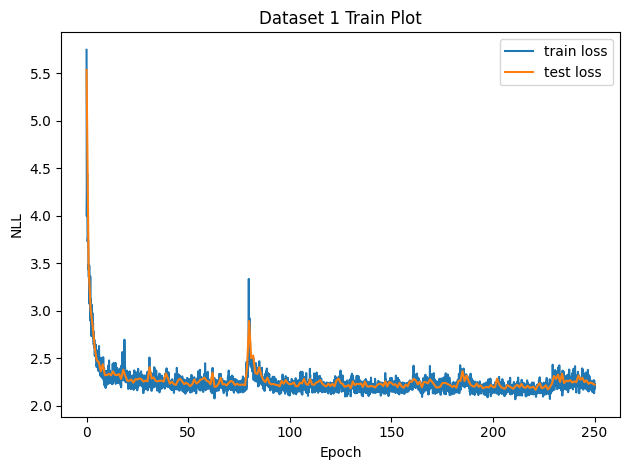

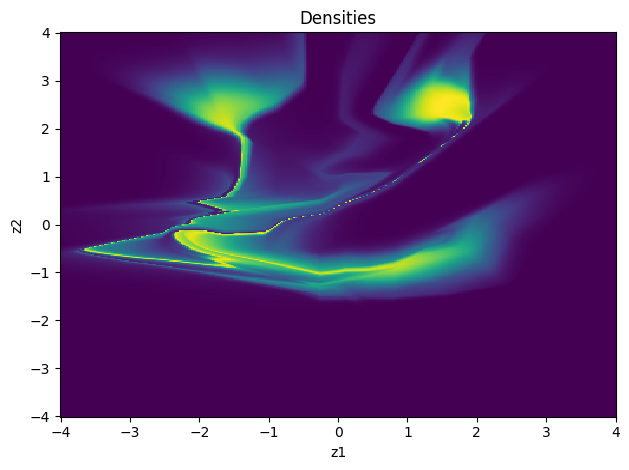

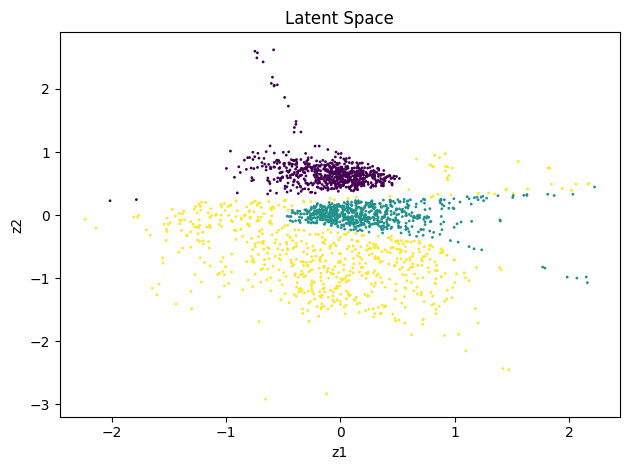

In [11]:
q1_save_results(1, 'b', q1_b)

Epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Final Test Loss: 2.0252


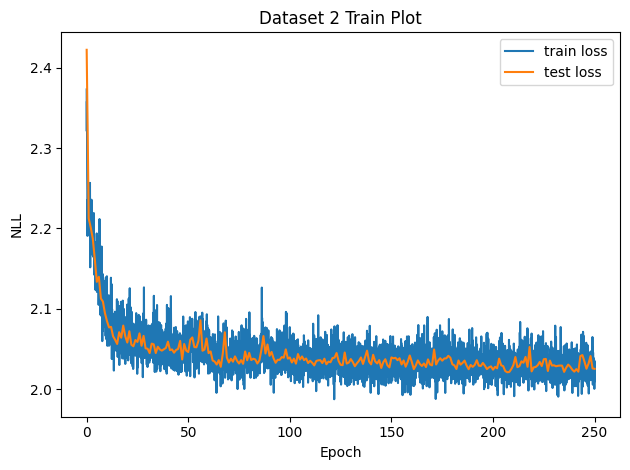

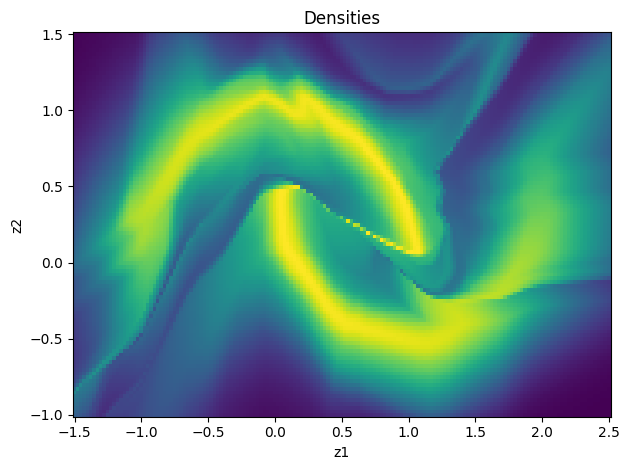

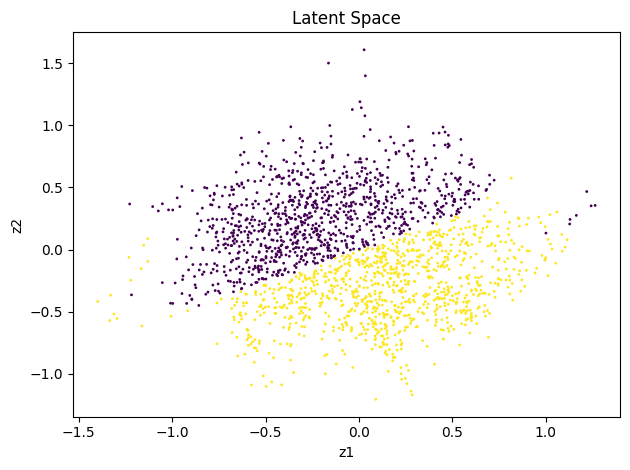

In [12]:
q1_save_results(2, 'b', q1_b)

# Autoregressive Flows for Images
We can scale up the autoregressive flows to high-dimensional image data. In this, we will focus on the black-and-white shapes dataset.

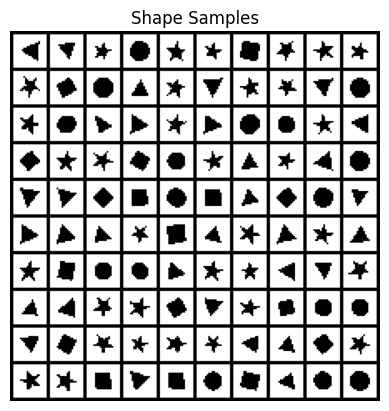

In [13]:
visualize_q2_data()

We will adapt out PixelCNN implementation and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture, output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: we must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**Over the course of training we will**

1.   Record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


In [14]:
def train_with_dequantization_q2(model, train_loader, optimizer):
    model.train()
    losses = []
    for x in train_loader:
        x = x.to(ptu.device).float().contiguous() #(bs, 1, 20, 20)
        x += torch.distributions.Uniform(0.0, 0.5).sample(x.shape).to(ptu.device) # add uniform noise to a batch - dequantization
        loss = model.nll(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

def train_epochs_q2(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, test_losses = [], []
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        model.train()
        epoch_train_losses = train_with_dequantization_q2(model, train_loader, optimizer)
        train_losses.extend(epoch_train_losses)
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        
    return train_losses, test_losses

In [24]:
ptu.set_gpu_mode(True)

class MaskConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        assert mask_type == 'A' or mask_type == 'B'
        
        # For 1st layer (input layer)
        # args = (in_channels, out_channels) --> (1, 64), kwargs = (7, 3)=(kernal_size, padding)
        
        # For subsequent layers
        # args = (in_channels, out_channels) --> (64, 64), kwargs = (7, 3)=(kernal_size, padding)
        # padding added to retain the size of feature map to 20 x 20
        
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight)) # self.weight is an atrribute of nn.Conv2d with shape (out_channels, in_channels, kernel_size[0], kernel_size[1])
        self.create_mask(mask_type)
        
    def forward(self, input, cond=None):
        batch_size = input.shape[0]
        # applies masked conv2d (multiples weight with mask) - rest of the parameters 
        # are attributes of nn.Conv2d() class
        out = F.conv2d(input, self.weight*self.mask, self.bias, self.stride, 
                       self.padding, self.dilation, self.groups)
        return out
    
    def create_mask(self, mask_type):
        k = self.kernel_size[0]
        
        '''
        
        This creates a type A mask - prevents info flow from the pixel location [3, 3]
        which model is trying to predict
        
        [[1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]
        
        '''
        
        self.mask[:, :, :k//2] = 1
        self.mask[:, :, k//2, :k//2] = 1
        
        if mask_type == 'B':
            '''
            Type B mask: has the info flow from pixel location [3, 3] which model is 
            trying to predict

            [[1., 1., 1., 1., 1., 1., 1.],
            [1., 1., 1., 1., 1., 1., 1.],
            [1., 1., 1., 1., 1., 1., 1.],
            [1., 1., 1., 1., 0., 0., 0.],
            [0., 0., 0., 0., 0., 0., 0.],
            [0., 0., 0., 0., 0., 0., 0.],
            [0., 0., 0., 0., 0., 0., 0.]]
            '''  
            self.mask[:, :, k//2, k//2] = 1

class ResBlock(nn.Module):
    def __init__(self, in_channels, **kwargs):
        super().__init__()
        self.block = nn.ModuleList([
            nn.ReLU(),
            MaskConv2d('B', in_channels, in_channels // 2, 1, **kwargs),
            nn.ReLU(),
            MaskConv2d('B', in_channels // 2, in_channels // 2, 7, padding=3, **kwargs),
            nn.ReLU(),
            MaskConv2d('B', in_channels // 2, in_channels, 1, **kwargs)
        ])

    def forward(self, x, cond=None):
        out = x
        for layer in self.block:
            if isinstance(layer, MaskConv2d):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        return out + x
    
class LayerNorm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
         #args = # output_filters,  kwargs = {}
        super().__init__(*args, **kwargs) # initializes LayerNorm with no. of output filters
    
    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous() # (bs, h, w, ch) 
        x_shape = x.shape
        x = super().forward(x) # (bs, h, w, ch)  
        return x.permute(0, 3, 1, 2).contiguous() # (bs, ch, h, w)

class AutoregressiveFlowPixelCNN(nn.Module):
    def __init__(self, input_shape, n_filters=64,
                 kernel_size=7, n_layers=5, use_resblock=False,
                 n_components=2, **kwargs):
        super().__init__()
        assert n_layers >= 2
        n_channels = input_shape[0] # 1
        
        if use_resblock: # False
            block_init = lambda: ResBlock(n_filters, **kwargs)
        else:
            # creates a lambda function block_init for MaksConv2d, function (not called here), 
            # parameters passed are the parameters for Conv layer
            block_init = lambda: MaskConv2d('B', n_filters, n_filters,
                                            kernel_size=kernel_size,
                                            padding=kernel_size // 2, **kwargs)
        
        # Create a Masked conv layer of type A (and append to the model) 
        model = nn.ModuleList([MaskConv2d('A', n_channels, n_filters, 
                                          kernel_size=kernel_size,
                                          padding=kernel_size // 2, **kwargs)])
        
        # n_layers = 5     
    
        # After adding one Type A Masked Conv2d layer, it adds n_layers of 
        # (LayerNorm, ReLU, Type B Masked Conv2d layer)
        
        for _ in range(n_layers):
            model.append(LayerNorm(n_filters))
            model.extend([nn.ReLU(), block_init()])
            
        # At the end it adds two Type B Masked Conv2d layer 
        
        model.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_filters, 1, **kwargs)])
        # last conv layer output is of shape (bs, 30, 20, 20) where 30 represents parameters (means, std, and mixtture weight) of each of the 10 components
        model.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_components*3*n_channels, 1, **kwargs)])
        
        self.net = model
        self.input_shape = input_shape # (1, 20, 20)
        self.n_channels = n_channels # 1
        self.n_components = n_components # 10
    
    def forward(self, x, cond=None):
        batch_size = x.shape[0]
        out = x.float()
        for layer in self.net:
            if isinstance(layer, MaskConv2d) or isinstance(layer, ResBlock):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        # resize the output of last layer to  (bs, 30, 1, 20, 20) where 30 represents parameters (means, std, and mixtture weight) of each of the 10 components
        return out.view(batch_size, 3*self.n_components, *self.input_shape)
    
    def nll(self, x, cond=None):
        '''
        every pixel location at each channel is a random variable. In the case we have 1 channel and
        spatial dimension as 20 x 20. Therefore, in total we have 400 random variables.
        
        Using the autoregressive model and the previous pixel location we predict means, std and mixture weights of componets for the next
        pixel location 
        
        Then to calculate z for the current pixel location, we use the the cdf (from predicted means, std and mixture weights) and current pixel values 
        '''
        # each is of shape (bs, 10, 1, 20, 20)
        loc, log_scale, weight_logits = torch.chunk(self.forward(x), 3, dim=1)
        weights = F.softmax(weight_logits, dim=1) # softmax over mixture weights logits
        # dz/dx is pdf as the flow is the cdf of mixture of Normal Distribution, z is Uniformly distributed and doesn't contribute to the gradient as log(1) = 0
        # log_scale.exp() to get the std
        log_det_jacobian = Normal(loc, log_scale.exp()).log_prob(x.unsqueeze(1).repeat(1, 1, self.n_components, 1, 1)) # (bs, 10, 10, 20, 20) # calculate log pdf where pdf is mixture of 10 Normal distribution
        return -log_det_jacobian.mean()
    
    def sample(self, n, cond=None):
        # Sample in the autoregressive fashion
        samples = torch.zeros(n, *self.input_shape).cuda() #tensor of shape (100, 1, 20, 20) of all zeros
        with torch.no_grad():
            # sample values at every pixel location for every channel one by one 
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    out = self.forward(samples)
                    for k in range(self.n_channels):
                        # get the parameters of mixture of Normals for next pixel lication for all channels
                        
                        # loc, log_scale, weight_logits = torch.chunk(self.forward(samples), 3, dim=1)
                        loc, log_scale, weight_logits = torch.chunk(out, 3, dim=1)
                        
                        # get the parameters of mixture of Normals for next pixel lication for the given channel
                        loc, log_scale, weight_logits = loc[:,:,k,r,c], log_scale[:,:,k,r,c], weight_logits[:,:,k,r,c]
                        probs = F.softmax(weight_logits, dim=1) # softmax over mixtire weights
                        # pick a Normal component assuming multinomial distribution (probability as mixture weights)
                        chosen_centers = torch.multinomial(probs, 1).squeeze(-1)
                        # From the chosen Normal component, randomly sample a number and initialize the pixel location with that value
                        samples[:, k, r, c] = torch.normal(loc[torch.arange(n), chosen_centers], log_scale[torch.arange(n), chosen_centers].exp())
        return samples.permute(0, 2, 3, 1).cpu().numpy()

In [25]:
def q2(train_data, test_data):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    H = W = 20
    Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
    """
      
    # train_data is of shape (10479, 20, 20, 1), test_data is of shape (4491, 20, 20, 1)
    # where every pixel is either 0 or 1

    train_data = np.transpose(train_data, (0, 3, 1, 2)).astype(np.float32) / 2.0 # (10479, 1, 20, 20) where every pixel is either 0 or 0.5
    test_data = np.transpose(test_data, (0, 3, 1, 2)).astype(np.float32) / 2.0 # (4491, 1, 20, 20) where every pixel is either 0 or 0.5
    # train_data = train_data + np.random.uniform(high=0.5, size=train_data.shape)
    test_data = test_data + np.random.uniform(high=0.5, size=test_data.shape) # test data is added with uniform noise - dequantization 

    H, W = 20, 20
    model = AutoregressiveFlowPixelCNN((1, H, W), n_layers=5, n_components=10).cuda()

    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs_q2(model, train_loader, test_loader, 
                                           dict(epochs=20, lr=1e-3))
    samples = model.sample(100)
    return train_losses + np.log(2), test_losses + np.log(2), samples

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Final Test Loss: 0.2278


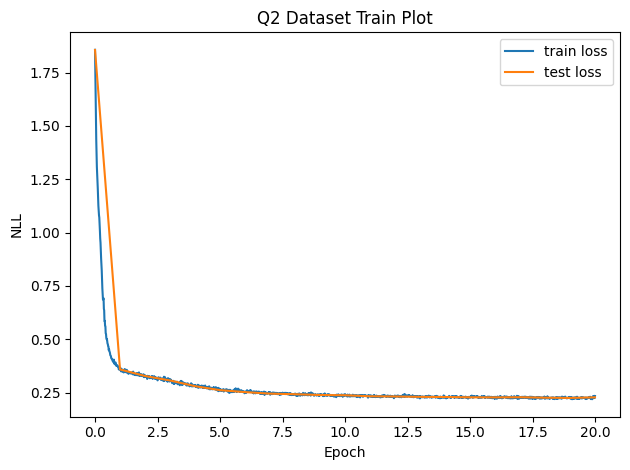

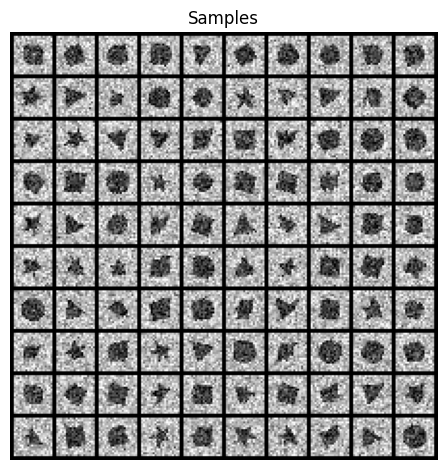

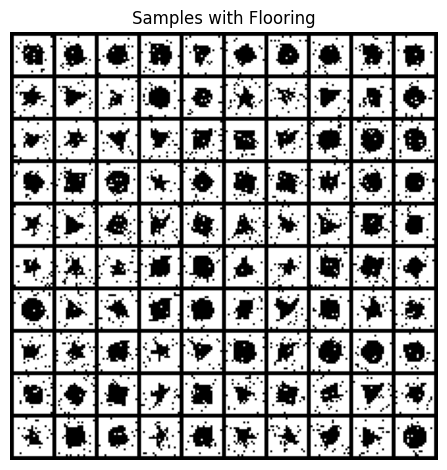

In [17]:
q2_save_results(q2)

# RealNVP on Higher Dimensions

In this we will train a flow model to invertibly map a high dimensional dataset of celebrity faces to gaussian noise. The dataset is a low-resolution (32 × 32) version of the CelebA-HQ dataset that has been quantized to 2 bits per color channel.

We will use the affine coupling flow from RealNVP and a form of [data-dependent initialization](https://arxiv.org/abs/1602.07868) that normalizes activations from an initial forward pass with a minibatch.

**Reference Architecture:**

```
Preprocess() # dequantization, logit trick from RealNVP (Dinh et al) Section 4.1

for _ in range(4):
  AffineCouplingWithCheckerboard() # Figure 3 in Dinh et al - (left)
  ActNorm() # described in Glow (Kingma & Dhariwal) Section 3.1
Squeeze(), # [b, c, h, w] --> [b, c*4, h//2, w//2]

for _ in range(3):
  AffineCouplingWithChannel()
  ActNorm()
Unsqueeze(), # [b, c*4, h//2, w//2] --> [b, c, h, w]

for _ in range(3):
  AffineCouplingWithCheckerboard()
  ActNorm()
```


We use an Adam Optimizer with a warmup over 200 steps till a learning rate of 5e-4. We didn’t decay the learning rate but it is a generally recommended practice while training generative models. We show samples from our model at the end of training, as well as interpolations between several images in our dataset.  Our reference solution achieves a test loss of about 0.40 bits/dim after 100 epochs. 

**Over the course of training, we will**


1.   Record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model
4. 5 rows of interpolations between images in the test set; each row consists of the start and end images, and 4 intermediate ones. 


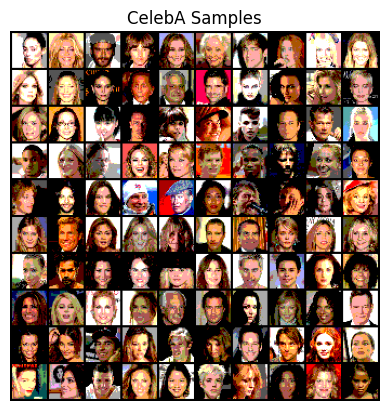

In [18]:
visualize_q3_data()

In [26]:
from torch.autograd import Variable
from tqdm import trange, tqdm, tqdm_notebook
import time

device = "cuda" 

# conv2d with weight normalization...
class WeightNormConv2d(nn.Module):
    '''
    Apply weight normalization to a parameter in the given module. 
    By default, with dim=0, the norm is computed independently per output channel i.e. with kernel of
    shape, let's (in_channels = 3, out_channels = 128, h, w) norm is computed across all the 3 channels
    for 128 channels seperately (there will be 128 norms calculated)
    '''
    def __init__(self, in_dim, out_dim, kernel_size, stride=1, padding=0,
                 bias=True):
        super(WeightNormConv2d, self).__init__()
        self.conv = nn.utils.weight_norm(
            nn.Conv2d(in_dim, out_dim, kernel_size,
                      stride=stride, padding=padding, bias=bias))

    def forward(self, x):
        return self.conv(x)

class ActNorm(nn.Module):
    def __init__(self, n_channels):
        super(ActNorm, self).__init__()
        # even though shift and log scale is initialized here, it's reinitialized with the first batcg
        # we need this to include shift and log_scale in model.paramters()
        self.log_scale = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.shift = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.n_channels = n_channels
        self.initialized = False

    def forward(self, x, reverse=False):
        if reverse:
            return (x - self.shift) * torch.exp(-self.log_scale), self.log_scale
        else:
            # uses first batch of data to initialize scale and shift. After that it is trained            
            if not self.initialized:
                # shift and scale is calculated per channel acrosss all samples
                self.shift.data = -torch.mean(x, dim=[0, 2, 3], keepdim=True) 
                self.log_scale.data = - torch.log(
                    torch.std(x.permute(1, 0, 2, 3).reshape(self.n_channels, -1), dim=1).reshape(1, self.n_channels, 1,
                                                                                                 1))
                self.initialized = True
                result = x * torch.exp(self.log_scale) + self.shift
            return x * torch.exp(self.log_scale) + self.shift, self.log_scale # returns the trainsformed data as well as the log_scale fort dz/dx(required to calculate likelihood)

class ResnetBlock(nn.Module):
    '''
    One Resnet block:
            # - 1 x 1 weight normalized conv2d, ReLU
            # - 3 x 3 weight normalized conv2d with padding=1 (to retain spatila dim, ReLU
            # - 1 x 1 weight normalized conv2d
    
    Both n_channels = 128 and spatial size of 32 x 32 is maintained 
    '''
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.block = nn.Sequential(
            WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0))

    def forward(self, x):
        return x + self.block(x)

class SimpleResnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=6, n_filters=128, n_blocks=8):
        super(SimpleResnet, self).__init__()
        layers = [WeightNormConv2d(in_channels, n_filters, (3, 3), stride=1, padding=1),
                  nn.ReLU()] # one weight normalization conv2d with padding to retain the shape
        # n_blocks = 8
        # 8 Resnet blocks
        for _ in range(n_blocks):
            layers.append(ResnetBlock(n_filters))
            
        # ReLu and final 1 weight normalization conv2d with padding ot retain the shape. 
        
        # The final shape of simple resent network for checkerboard transform is (bs, 6, 32, 32)
        # for every pixel (across all channels), we have 1 shift and 1 scale  
        
        # The final shape of simple resent network for channnlel transform is (bs, 12, 32, 32)
        # for every pixel of either top/bottom 6 channels we have 1 shift and 1 scale
        
        layers.append(WeightNormConv2d(n_filters, out_channels, (3, 3), stride=1, padding=1))
        self.resnet = nn.Sequential(*layers)

    def forward(self, x):
        return self.resnet(x)

class AffineCheckerboardTransform(nn.Module):
    def __init__(self, type=1.0):
        super(AffineCheckerboardTransform, self).__init__()
        self.mask = self.build_mask(type=type)
        
        # log_scale=scale×𝑡𝑎𝑛ℎ(𝑔𝜃,scale(𝑥1))+scale_shift
        # one scale and scale_shift is used for all pixels spatially and across channels
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.resnet = SimpleResnet() # resnet network

    def build_mask(self, type=1.0):
        # if type == 1.0, the top left corner will be 1.0
        # if type == 0.0, the top left corner will be 0.0
        '''
        [[ 0  1  2 ... 29 30 31]
        [ 1  2  3 ... 30 31 32]
        [ 2  3  4 ... 31 32 33]
        ...
        [29 30 31 ... 58 59 60]
        [30 31 32 ... 59 60 61]
        [31 32 33 ... 60 61 62]]
        (32, 32)
        '''
        mask = np.arange(32).reshape(-1, 1) + np.arange(32)
        
        '''
        Type = 1
        [[1. 0. 1. ... 0. 1. 0.]
         [0. 1. 0. ... 1. 0. 1.]
         [1. 0. 1. ... 0. 1. 0.]
         ...
         [0. 1. 0. ... 1. 0. 1.]
         [1. 0. 1. ... 0. 1. 0.]
         [0. 1. 0. ... 1. 0. 1.]]
        (32, 32)
        
        Type = 2
        [[0. 1. 0. ... 1. 0. 1.]
         [1. 0. 1. ... 0. 1. 0.]
         [0. 1. 0. ... 1. 0. 1.]
         ...
         [1. 0. 1. ... 0. 1. 0.]
         [0. 1. 0. ... 1. 0. 1.]
         [1. 0. 1. ... 0. 1. 0.]]
        (32, 32)
        '''        
        mask = np.mod(type + mask, 2)
        
        '''
        Type = 1
        [[[[1. 0. 1. ... 0. 1. 0.]
         [0. 1. 0. ... 1. 0. 1.]
         [1. 0. 1. ... 0. 1. 0.]
         ...
         [0. 1. 0. ... 1. 0. 1.]
         [1. 0. 1. ... 0. 1. 0.]
         [0. 1. 0. ... 1. 0. 1.]]]]
        (1, 1, 32, 32)
        
        Type = 2
        [[[[0. 1. 0. ... 1. 0. 1.]
         [1. 0. 1. ... 0. 1. 0.]
         [0. 1. 0. ... 1. 0. 1.]
         ...
         [1. 0. 1. ... 0. 1. 0.]
         [0. 1. 0. ... 1. 0. 1.]
         [1. 0. 1. ... 0. 1. 0.]]]]
        (1, 1, 32, 32)
        '''

        mask = mask.reshape(-1, 1, 32, 32)
        return torch.tensor(mask.astype('float32')).to(device)

    def forward(self, x, reverse=False):
        # returns transform(x), log_det
        batch_size, n_channels, _, _ = x.shape # 64, 3, _, _
        mask = self.mask.repeat(batch_size, 1, 1, 1)
        
        x_ = x * mask # using the pixel values whose mask value is 1 to predict shift and log_scale for the other set of pixels
        # self.resnet(x_) - (bs, 6, 32, 32)
        log_s, t = self.resnet(x_).split(n_channels, dim=1) # (bs, 3, 32, 32), (bs, 3, 32, 32) sperating shift and scale
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift # log_scale=scale×𝑡𝑎𝑛ℎ(𝑔𝜃,scale(𝑥1))+scale_shift
        
        # To apply the transformation only to pixels whose mask = 0 and retain the pixel whose mask = 1
        # , we make t = 0 and log_s = 0 for pixel values whose mask = 1
        t = t * (1.0 - mask)
        log_s = log_s * (1.0 - mask)

        if reverse:  # inverting the transformation
            x = (x - t) * torch.exp(-log_s)
        else:
            # transfromation
            x = x * torch.exp(log_s) + t
            
        return x, log_s # returns the the value (bs, 3, 32, 32) as well as dz/dx (bs, 3, 32, 32)

class AffineChannelTransform(nn.Module):
    def __init__(self, modify_top):
        super(AffineChannelTransform, self).__init__()
        
        # if True - top half of channels undergoes affine transformation
        # if False - bottom half od channels undergoes affine transformation
        self.modify_top = modify_top
        
        # log_scale=scale×𝑡𝑎𝑛ℎ(𝑔𝜃,scale(𝑥1))+scale_shift
        # one scale and scale_shift is used for all pixels spatially and across channels
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.resnet = SimpleResnet(in_channels=6, out_channels=12)

    def forward(self, x, reverse=False):
        n_channels = x.shape[1] # 3*4
        
        # split the tensor into two across channels
        if self.modify_top:
            on, off = x.split(n_channels // 2, dim=1) # (bs, 6, 32/2, 32/2), (bs, 6, 32/2, 32/2)
        else:
            off, on = x.split(n_channels // 2, dim=1) #(bs, 6, 32/2, 32/2), (bs, 6, 32/2, 32/2)
            
        # feed the top/bottom half of channels to Resnet to get log_s and t
        
        # self.resnet(off) --> (bs, 12, 32/2, 32/2) -> since we feed only half of the input, we get shift and scale for the other half
        # for checkerboard transform, we fed the entire input after masking, we got shift and scale for entire input which we further masked
        # to prevent affine transformation of one half
        
        # separate shift and scale
        log_s, t = self.resnet(off).split(n_channels // 2, dim=1) # (bs, 6, 32/2, 32/2), (bs, 6, 32/2, 32/2)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift # log_scale=scale×𝑡𝑎𝑛ℎ(𝑔𝜃,scale(𝑥1))+scale_shift

        if reverse:  # inverting the transformation
            on = (on - t) * torch.exp(-log_s)
        else:
            # affine transformation
            on = on * torch.exp(log_s) + t
        
        # concatenate the two halves (one transformed and one unchanged). Also, dz/dx for the untransformer half is 0
        if self.modify_top:
            return torch.cat([on, off], dim=1), torch.cat([log_s, torch.zeros_like(log_s)], dim=1) # (bs, 12, 32/2, 32/2), (bs, 12, 32/2, 32/2)
        else:
            return torch.cat([off, on], dim=1), torch.cat([torch.zeros_like(log_s), log_s], dim=1) # (bs, 12, 32/2, 32/2), (bs, 12, 32/2, 32/2)

class RealNVP(nn.Module):
    def __init__(self):
        super(RealNVP, self).__init__()

        self.prior = torch.distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device)) # target distribution of Pz(z1), Pz(z2/z1)...etc is all Normal Distribution
        # self.prior = torch.distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))
        
        # Define a checkerboard_transforms (with alternate masking type) and ActNorm
        self.checker_transforms1 = nn.ModuleList([
            AffineCheckerboardTransform(1.0),
            ActNorm(3),
            AffineCheckerboardTransform(0.0),
            ActNorm(3),
            AffineCheckerboardTransform(1.0),
            ActNorm(3),
            AffineCheckerboardTransform(0.0)
        ])

        self.channel_transforms = nn.ModuleList([
            AffineChannelTransform(True),
            ActNorm(12),
            AffineChannelTransform(False),
            ActNorm(12),
            AffineChannelTransform(True),
        ])

        self.checker_transforms2 = nn.ModuleList([
            AffineCheckerboardTransform(1.0),
            ActNorm(3),
            AffineCheckerboardTransform(0.0),
            ActNorm(3),
            AffineCheckerboardTransform(1.0)
        ])

    def squeeze(self, x):
        # C x H x W -> 4C x H/2 x W/2
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
        return x

    def undo_squeeze(self, x):
        #  4C x H/2 x W/2  ->  C x H x W
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
        return x

    def g(self, z):
        # z -> x (inverse of f)
        '''
        We feed z to the revrese order of network i.e. we feed it first to reversed(self.checker_transforms2), then
        reversed(self.channel_transforms) and then reversed(self.checker_transforms1).
        
        When we look at the last layer of self.checker_transforms2, it's AffineCheckerboardTransform(1) which is invertible.
        So, when we pass z to this, half of Zs (alternate positions) is copied as it is. So when we think
        of the forward pass, these half Zs is exactly same as half of Xs fed as input. Since these half Zs is used to
        calculate scale and shift for other half, values of scale and shift would be same as during forward pass since halfof Zs
        and half of Xs are same. So, when we apply inverse transformation on the other half Zs using this scale and shift we would 
        get same other half of Xs that would have produced the given other half of Zs.
        
        It follows the above with all the other layers. So ultimately, we would get the Xs from Zs such that Xs that we get 
        would produce same Zs in the forward pass.
        
        '''
        x = z
        for op in reversed(self.checker_transforms2):
            x, _ = op.forward(x, reverse=True)
        x = self.squeeze(x)
        for op in reversed(self.channel_transforms):
            x, _ = op.forward(x, reverse=True)
        x = self.undo_squeeze(x)
        for op in reversed(self.checker_transforms1):
            x, _ = op.forward(x, reverse=True)
        return x

    def f(self, x):
        # maps x -> z, and returns the log determinant (not reduced)
        # log_det is of shape (bs, 3, 32, 32) --> accummulates dz/dx for all (3, 32, 32) pixels for every sample
        z, log_det = x, torch.zeros_like(x)
        
        # forward pass through self.checker_transforms1
        for op in self.checker_transforms1:
            z, delta_log_det = op.forward(z) # (bs, 3, 32, 32), (bs, 3, 32, 32)
            log_det += delta_log_det
            
        z, log_det = self.squeeze(z), self.squeeze(log_det) # (bs, 3*4, 32/2, 32/2),  (bs, 3*4, 32/2, 32/2)
        
        # forward pass through self.channel_transforms
        for op in self.channel_transforms:
            z, delta_log_det = op.forward(z) # (bs, 12m 32/2, 32/2) (bs, 12, 32/2, 32/2)
            log_det += delta_log_det
        
        z, log_det = self.undo_squeeze(z), self.undo_squeeze(log_det) # (bs, 3, 32, 32), (bs, 3, 32, 32)
        
         # forward pass through self.checker_transforms2
        for op in self.checker_transforms2:
            z, delta_log_det = op.forward(z) # (bs, 3, 32, 32), (bs, 3, 32, 32)
            log_det += delta_log_det
        return z, log_det # (bs, 3, 32, 32), (bs, 3, 32, 32)

    def log_prob(self, x):
        z, log_det = self.f(x)
        # for every sample calculate P(x) = Pz(z1) + dz1/dx1 + P(z2/z1) + dz2/dx2 + ....
        return torch.sum(log_det, [1, 2, 3]) + torch.sum(self.prior.log_prob(z), [1, 2, 3]) # (bs,)

    def sample(self, num_samples):
        z = self.prior.sample([num_samples, 3, 32, 32]) # Sample 100 images of shape (3, 32, 32) from Pz ~ Normal
        return self.g(z) # inverse of Z

class Solver(object):
    def __init__(self, learning_rate=5e-4, n_epochs=128):
        self.train_loader, self.val_loader = self.create_loaders() # creates train and test dataloader
        self.log_interval = 100
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.n_batches_in_epoch = len(self.train_loader)

    def build(self):
        self.flow = RealNVP().to(device)
        self.optimizer = torch.optim.Adam(self.flow.parameters(), lr=self.learning_rate)

    def create_loaders(self):
        train, test = get_q3_data() # reads the `data/celeb.pkl'
        train = np.transpose(train, axes=[0, 3, 1, 2])  # NCHW 20000 x 3 x 32 x 32
        test = np.transpose(test, axes=[0, 3, 1, 2])  # NCHW 6838 x 3 x 32 x 32
        train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=False, pin_memory=False)
        test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False, pin_memory=False)
        return train_loader, test_loader

    def preprocess(self, x, reverse=False, dequantize=True):
        # revrese of dequantization (used when sampling)
        if reverse:  # doesn't map back to [0, 4]
            x = 1.0 / (1 + torch.exp(-x))
            x -= 0.05
            x /= 0.9
            return x
        else:
            # dequantization - from RealNVP (Dinh et al) Section 4.1
            if dequantize:
                x += torch.distributions.Uniform(0.0, 1.0).sample(x.shape).to(device)
            x /= 4.0

            # logit operation
            x *= 0.9
            x += 0.05
            logit = torch.log(x) - torch.log(1.0 - x)
            log_det = torch.nn.functional.softplus(logit) + torch.nn.functional.softplus(-logit) \
                      + torch.log(torch.tensor(0.9)) - torch.log(torch.tensor(4.0))
            return logit, torch.sum(log_det, dim=(1, 2, 3))

    def train(self):
        train_losses = []
        val_losses = []
        for epoch_i in range(self.n_epochs):
            epoch_i += 1

            self.flow.train()
            self.batch_loss_history = []

            for batch_i, image in enumerate(tqdm_notebook(
                    self.train_loader, desc='Batch', leave=False)):

                batch_i += 1
                # [batch_size, 3, 32, 32]
                image = Variable(image).to(device)
                # image dequantization
                logit_x, log_det = self.preprocess(image.float()) # (bs, 3, 32, 32), (64,)
                log_prob = self.flow.log_prob(logit_x) # (bs,) log P(x) for every sample
                log_prob += log_det
                
                # negative mean likelihood and normalize
                batch_loss = -torch.mean(log_prob) / (3.0 * 32.0 * 32.0)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                batch_loss = float(batch_loss.data)
                self.batch_loss_history.append(batch_loss)
            
            epoch_loss = np.mean(self.batch_loss_history)
            tqdm.write(f'Epoch {epoch_i} Loss: {epoch_loss:.2f}')
            
            #save model after every 10 epochs
            if epoch_i % 10 == 0:
                self.save_model("realnvp{}.model".format(str(epoch_i)))
            # overwrite train_losses.npy and val_losses.npy by adding loss after every epoch
            train_losses.append(epoch_loss)
            val_losses.append(self.get_loss(self.val_loader))
            np.save("train_losses.npy", np.array(train_losses))
            np.save("val_losses.npy", np.array(val_losses))
        
        # Save final model after 100 epochs
        self.save_model("realnvp_final.model")
        return train_losses, val_losses

    def get_loss(self, loader):
        """Compute error on provided data set"""
        errors = []
        # cuda.synchronize()
        start = time.time()

        self.flow.eval()

        for image in loader:
            with torch.no_grad():
                image = image.to(device)
                # image dequantization
                logit_x, log_det = self.preprocess(image.float())
                log_prob = self.flow.log_prob(logit_x)
                log_prob += log_det

                loss = -torch.mean(log_prob) / (3.0 * 32.0 * 32.0) # mean across 
                error = float(loss.data)
                errors.append(error)

        # cuda.synchronize()
        time_test = time.time() - start
        log_string = f'Calc done! | It took {time_test:.1f}s | '
        log_string += f'Loss: {np.mean(errors):.2f}'
        tqdm.write(log_string)
        return np.mean(errors)

    def sample(self, num_samples):
        with torch.no_grad():
            raw_samples = self.flow.sample(num_samples).cpu()
            samples = self.preprocess(raw_samples, reverse=True) # inverse transformation and inverse dequatization
            return samples.cpu().numpy()

    def interpolate(self):
        self.flow.eval()
        good = [5, 13, 16, 19, 22]
        indices = []
        for index in good:
            indices.append(index*2)
            indices.append(index*2+1)
        # indices = [10, 11, 26, 27, 32, 33, 38, 39, 44, 45] # it represents indices start and end images in the val set
        with torch.no_grad():
            '''
            Take the first pair of indices, load the start and end images from the val set.
            Pass both the images through the flow to get latent variable a and b.
            Now interpolate in the latent space - 5 interpolated equally spaced latent points and pass it 
            to inverse of flow to get back the image from interpolated latent points
            
            Repeeat the same for other pairs of start and end images
            '''
            actual_images = next(iter(self.val_loader))[indices].to('cpu')
            assert actual_images.shape[0] % 2 == 0
            logit_actual_images, _ = self.preprocess(actual_images.float(), dequantize=False)
            latent_images, _ = self.flow.f(logit_actual_images)
            latents = []
            for i in range(0, actual_images.shape[0], 2):
                a = latent_images[i:i+1]
                b = latent_images[i + 1:i+2]
                diff = (b - a)/5.0
                latents.append(a)
                for j in range(1, 5):
                    latents.append(a + diff * float(j))
                latents.append(b)
            latents = torch.cat(latents, dim=0)
            logit_results = self.flow.g(latents)
            results = self.preprocess(logit_results, reverse=True)
            return results.cpu().numpy()

    def save_model(self, filename):
        torch.save(self.flow, filename)

    def load_model(self, filename):
        self.flow = torch.load(filename, map_location="cpu")
     

In [27]:
def q3_a(train_data, test_data):
    """
    train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
    - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
    """
    
    solver = Solver(n_epochs=1)
    solver.build() # build the network
    solver.load_model("realnvp_final.model") #load the trained model
    train_losses = np.load('train_losses.npy')
    test_losses = np.load('val_losses.npy')
    samples = np.transpose(solver.sample(100), axes=[0, 2, 3, 1]) # sampling and reshaping it to (100, 32, 32, 3)
    interpolations = np.transpose(solver.interpolate(), axes=[0, 2, 3, 1])
    return train_losses, test_losses, samples, interpolations

In [28]:
solver = Solver(n_epochs=100) # initialzes dataloaders and training hyperparmaters
solver.build() # build the network
train, val = solver.train() # train and save the model

Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1 Loss: 0.78
Calc done! | It took 36.9s | Loss: 0.64


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2 Loss: 0.62
Calc done! | It took 37.0s | Loss: 0.60


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3 Loss: 0.59
Calc done! | It took 37.0s | Loss: 0.58


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4 Loss: 0.57
Calc done! | It took 37.0s | Loss: 0.56


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5 Loss: 0.56
Calc done! | It took 37.0s | Loss: 0.55


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6 Loss: 0.54
Calc done! | It took 37.2s | Loss: 0.54


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7 Loss: 0.53
Calc done! | It took 37.1s | Loss: 0.53


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8 Loss: 0.53
Calc done! | It took 36.8s | Loss: 0.52


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9 Loss: 0.52
Calc done! | It took 37.0s | Loss: 0.51


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10 Loss: 0.51
Calc done! | It took 37.2s | Loss: 0.51


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11 Loss: 0.51
Calc done! | It took 37.1s | Loss: 0.50


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12 Loss: 0.50
Calc done! | It took 36.8s | Loss: 0.50


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13 Loss: 0.50
Calc done! | It took 37.0s | Loss: 0.49


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14 Loss: 0.49
Calc done! | It took 37.0s | Loss: 0.49


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15 Loss: 0.49
Calc done! | It took 36.9s | Loss: 0.49


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16 Loss: 0.48
Calc done! | It took 37.2s | Loss: 0.49


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17 Loss: 0.48
Calc done! | It took 37.1s | Loss: 0.48


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18 Loss: 0.48
Calc done! | It took 36.9s | Loss: 0.48


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19 Loss: 0.48
Calc done! | It took 36.8s | Loss: 0.48


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20 Loss: 0.47
Calc done! | It took 36.9s | Loss: 0.48


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21 Loss: 0.47
Calc done! | It took 37.0s | Loss: 0.47


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22 Loss: 0.47
Calc done! | It took 36.8s | Loss: 0.47


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23 Loss: 0.47
Calc done! | It took 37.1s | Loss: 0.47


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24 Loss: 0.47
Calc done! | It took 37.1s | Loss: 0.47


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25 Loss: 0.46
Calc done! | It took 36.8s | Loss: 0.46


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26 Loss: 0.46
Calc done! | It took 36.9s | Loss: 0.46


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27 Loss: 0.46
Calc done! | It took 37.1s | Loss: 0.46


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28 Loss: 0.46
Calc done! | It took 37.1s | Loss: 0.46


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29 Loss: 0.46
Calc done! | It took 36.8s | Loss: 0.46


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30 Loss: 0.46
Calc done! | It took 37.0s | Loss: 0.46


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 31 Loss: 0.45
Calc done! | It took 36.9s | Loss: 0.45


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 32 Loss: 0.45
Calc done! | It took 36.9s | Loss: 0.45


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 33 Loss: 0.45
Calc done! | It took 36.8s | Loss: 0.45


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 34 Loss: 0.45
Calc done! | It took 36.9s | Loss: 0.45


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35 Loss: 0.45
Calc done! | It took 36.9s | Loss: 0.45


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 36 Loss: 0.45
Calc done! | It took 36.8s | Loss: 0.45


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 37 Loss: 0.44
Calc done! | It took 36.9s | Loss: 0.44


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 38 Loss: 0.44
Calc done! | It took 37.0s | Loss: 0.45


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 39 Loss: 0.44
Calc done! | It took 36.8s | Loss: 0.44


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40 Loss: 0.44
Calc done! | It took 36.8s | Loss: 0.44


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 41 Loss: 0.44
Calc done! | It took 37.1s | Loss: 0.44


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 42 Loss: 0.44
Calc done! | It took 37.0s | Loss: 0.44


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 43 Loss: 0.44
Calc done! | It took 36.8s | Loss: 0.44


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 44 Loss: 0.44
Calc done! | It took 36.9s | Loss: 0.44


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45 Loss: 0.44
Calc done! | It took 37.0s | Loss: 0.44


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 46 Loss: 0.44
Calc done! | It took 36.8s | Loss: 0.44


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 47 Loss: 0.43
Calc done! | It took 36.8s | Loss: 0.44


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 48 Loss: 0.43
Calc done! | It took 36.9s | Loss: 0.43


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 49 Loss: 0.43
Calc done! | It took 36.9s | Loss: 0.44


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 50 Loss: 0.43
Calc done! | It took 36.8s | Loss: 0.43


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 51 Loss: 0.43
Calc done! | It took 36.9s | Loss: 0.43


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 52 Loss: 0.43
Calc done! | It took 36.8s | Loss: 0.43


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 53 Loss: 0.43
Calc done! | It took 36.8s | Loss: 0.43


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 54 Loss: 0.43
Calc done! | It took 36.8s | Loss: 0.43


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 55 Loss: 0.43
Calc done! | It took 37.2s | Loss: 0.43


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 56 Loss: 0.43
Calc done! | It took 36.9s | Loss: 0.43


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 57 Loss: 0.43
Calc done! | It took 36.8s | Loss: 0.43


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 58 Loss: 0.43
Calc done! | It took 36.8s | Loss: 0.43


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 59 Loss: 0.43
Calc done! | It took 37.0s | Loss: 0.43


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 60 Loss: 0.42
Calc done! | It took 36.8s | Loss: 0.43


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 61 Loss: 0.42
Calc done! | It took 36.8s | Loss: 0.43


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 62 Loss: 0.42
Calc done! | It took 36.8s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 63 Loss: 0.42
Calc done! | It took 36.9s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 64 Loss: 0.42
Calc done! | It took 36.8s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 65 Loss: 0.42
Calc done! | It took 36.8s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 66 Loss: 0.42
Calc done! | It took 37.0s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 67 Loss: 0.42
Calc done! | It took 36.9s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 68 Loss: 0.42
Calc done! | It took 36.8s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 69 Loss: 0.42
Calc done! | It took 36.9s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 70 Loss: 0.42
Calc done! | It took 37.0s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 71 Loss: 0.42
Calc done! | It took 36.9s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 72 Loss: 0.42
Calc done! | It took 36.8s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 73 Loss: 0.42
Calc done! | It took 37.0s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 74 Loss: 0.42
Calc done! | It took 36.9s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 75 Loss: 0.41
Calc done! | It took 36.7s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 76 Loss: 0.41
Calc done! | It took 36.9s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 77 Loss: 0.41
Calc done! | It took 37.0s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 78 Loss: 0.41
Calc done! | It took 36.9s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 79 Loss: 0.41
Calc done! | It took 36.8s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 80 Loss: 0.41
Calc done! | It took 36.9s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 81 Loss: 0.41
Calc done! | It took 37.0s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 82 Loss: 0.41
Calc done! | It took 36.8s | Loss: 0.42


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 83 Loss: 0.41
Calc done! | It took 36.6s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 84 Loss: 0.41
Calc done! | It took 37.0s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 85 Loss: 0.41
Calc done! | It took 36.9s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 86 Loss: 0.41
Calc done! | It took 36.8s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 87 Loss: 0.41
Calc done! | It took 36.9s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 88 Loss: 0.41
Calc done! | It took 36.9s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 89 Loss: 0.41
Calc done! | It took 37.0s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 90 Loss: 0.41
Calc done! | It took 36.8s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 91 Loss: 0.41
Calc done! | It took 36.9s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 92 Loss: 0.41
Calc done! | It took 37.0s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 93 Loss: 0.41
Calc done! | It took 36.8s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 94 Loss: 0.41
Calc done! | It took 36.8s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 95 Loss: 0.41
Calc done! | It took 37.1s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 96 Loss: 0.41
Calc done! | It took 36.8s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 97 Loss: 0.41
Calc done! | It took 36.8s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 98 Loss: 0.40
Calc done! | It took 36.9s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 99 Loss: 0.40
Calc done! | It took 37.0s | Loss: 0.41


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 100 Loss: 0.40
Calc done! | It took 36.7s | Loss: 0.41


Final Test Loss: 0.4076


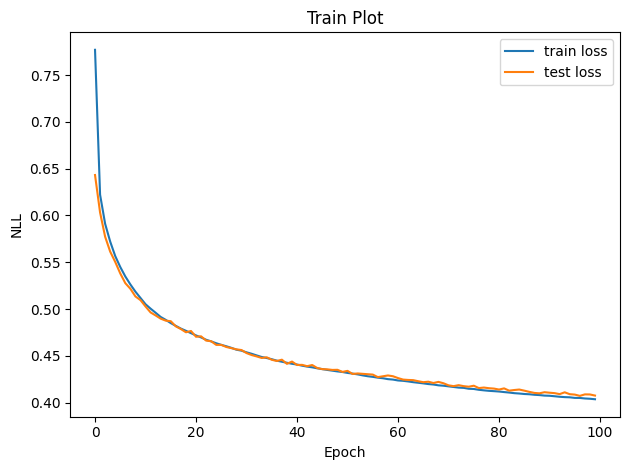

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


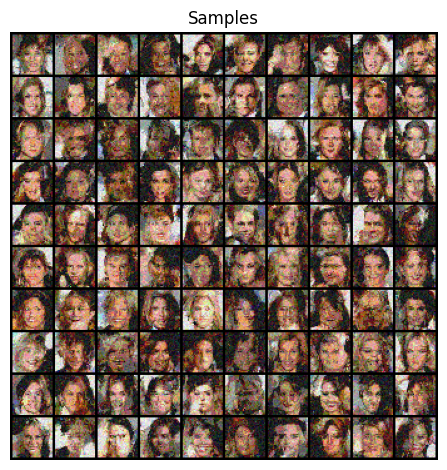

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


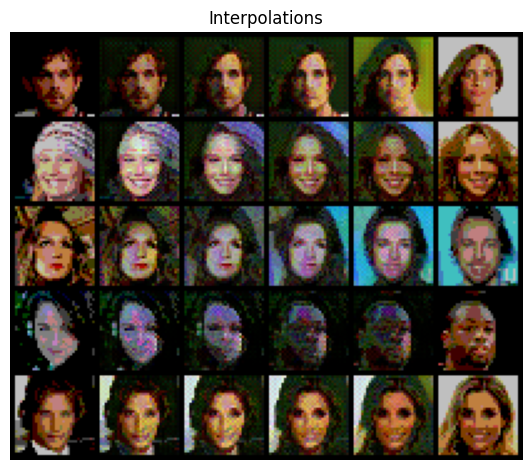

In [29]:
q3_save_results(q3_a, 'a')